# Notebook used in HPC at RWTH
1. Remember to change the number of parallel process

In [21]:
import numpy as np
from numpy import linalg as LA

from scipy import stats
from scipy import integrate
from scipy.optimize import minimize

import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import multiprocessing
print(multiprocessing.cpu_count())

import pandas as pd
import seaborn as sns

import time

from itertools import product, combinations_with_replacement
from numpy import linalg as LA

import os
from numba import float64,jit,prange,njit, vectorize, guvectorize
%matplotlib widget 

8


In [23]:
import matplotlib as mpl
from math import sqrt
def latexify(fig_width=None, fig_height=None, columns=1): 

    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches; default 3.404 (single col.), 6.9 (double col) inches
    fig_height : float,  optional, inches; default 3.4/1.6180=2.1013, 6.9/1.6180=2.7911
    columns : {1, 2}
    """
    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
    #                   http://scipy-cookbook.readthedocs.io/items/Matplotlib_LaTeX_Examples.html

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])
    
    fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
    inches_per_pt = 1.0/72.27               # Convert pt to inches
    golden_mean = (sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width0 = fig_width_pt*inches_per_pt  # width in inches
    fig_height0 =fig_width0*golden_mean       # height in inches
    fig_size0 = [fig_width0,fig_height0]
    
    if fig_width is None:
        #fig_width = 3.39 if columns==1 else 6.9 # width in inches
        fig_width = fig_width0 if columns==1 else 6.9 # width in inches
        
    if fig_height is None:
        fig_height = fig_height0 # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'pdf',
              #'text.latex.preamble'：'\usepackage{gensymb}',
              #'font.family': 'Arial',
			  #'font.family': 'sans-serif',  # used by text object
              'axes.titlesize': 8,#9, # 10,
              'axes.labelsize': 8,#9, # 10, # fontsize for x and y labels (was 10)
              'font.size': 8,#9, # 10, changed from 'text.fontsize'
              'legend.fontsize': 8,#9, # 10, 
              'xtick.labelsize': 7,#9,
              'ytick.labelsize': 7,#9,
              'xtick.direction': 'in',
              'ytick.direction': 'in',
              'text.usetex': False, # error if set to True
              'figure.figsize': [fig_width,fig_height],
              
              'mathtext.fontset':'custom',
              #'mathtext.rm':'Arial',
              #'mathtext.it':'Arial:italic',
              #'mathtext.bf':'Arial:bold'
			  
    }
    mpl.rcParams.update(params)
    return

# Constants and form factor

In [24]:
# Dipolar
S = 7/2
g = 2
uB = 9.274 * 10**-24 #Am2
u0 = 4 * 3.14* 10**-7 # Tm/A
aa = 10.4 # lattice parameter 10.4 from D7 and 10.49 from D2B
d = aa*np.sqrt(2)/4 * 10**-10

# Dipolar interaction in meV
print(
    u0*(S*g*uB)**2 / d**3 /(4*3.14) / (1.602176634*10**-22),  # with S^2
    u0*(S*g*uB)*((S+1)*g*uB) / d**3 /(4*3.14) / (1.602176634*10**-22), # with S(S+1)
    u0*(g*uB)**2 / d**3 /(4*3.14) / (1.602176634*10**-22) # without SS for SpinW
)

0.052912079732749674 0.06802981679924958 0.004319353447571402


In [25]:
# Compare the lattice parameter determined on D2B and D7
# Gd2Hf2O7: 10.49 @1.5K,D2B, 10.4@30K, D7
# Cu:       3.615 @300K Wiki., 3.566@D7
(10.49-10.4)/10.49, (3.615-3.566)/3.615

# Coulsiions: the detemined lattice parameters for GHO and Cu on D7 are about 1% smaller than the D2B one.

(0.008579599618684448, 0.013554633471646023)

In [26]:
0.3*3.5*4.5/11.6

0.40732758620689663

In [27]:
# Jnn
# Jex from Tcw=z J S(S+1) / 3kb for H= \sum_{i<j} Jex S_i \cdot S_j
# Tcw=z 2J S(S+1) / 3kb, in the Book by J W D Coey, Magnetism and magnetic materials H= 2 \sum_{i<j} Jex S_i \cdot S_j
print(-7.3 *3 / 6/S/(S+1) /11.6, 
      -7.3 *3 / 6 /11.6,
      -8.6 *3 / 6/S/(S+1), # reproduce in Ref.[3]
      -7.3 *3 / 6 /11.6)

-0.019978106185002738 -0.3146551724137931 -0.273015873015873 -0.3146551724137931


In [28]:
kb = 0.0862
JexGd = -0.3 #meV including S(S+1)
DipGd = 0.066 # including S(S+1), there is a minus sign in the interaction matrix
DanGd = 0.140/11.6 * 3.5*3.5 #meV, need to include S(S+1) or SS found on 2024.03.21; use GdSn one
print(DanGd)

# Atom positions
r0=np.array([0, 0, 0])/4
r1=np.array([1, 1, 0])/4
r2=np.array([1, 0, 1])/4
r3=np.array([0, 1, 1])/4
rs=np.vstack([r0,r1,r2,r3]).T
print(rs)

# Loacal 111 aixs
n0=[1, 1, 1]
n1=[-1, -1, 1]
n2=[-1, 1, -1]
n3=[1, -1, -1]
ns = np.vstack([n0,n1,n2,n3])/np.sqrt(3)
print(ns)

0.14784482758620693
[[0.   0.25 0.25 0.  ]
 [0.   0.25 0.   0.25]
 [0.   0.   0.25 0.25]]
[[ 0.57735027  0.57735027  0.57735027]
 [-0.57735027 -0.57735027  0.57735027]
 [-0.57735027  0.57735027 -0.57735027]
 [ 0.57735027 -0.57735027 -0.57735027]]


In [29]:
def gdformfact(q):# Gd3+ form factor
    s,j,l,ss = q/(4*np.pi), 7/2., 0, 7/2. ### Take care of the fraction 9/2=4
    fc = (j*(j+1)-ss*(ss+1)+l*(l+1))/(3*j*(j+1)+ss*(ss+1)-l*(l+1))
    
    j0 = [0.0186,25.3867,0.2895,11.1421,0.7135,3.7520,-0.0217]
    j2 = [0.3347,18.4758,1.2465,6.8767,0.9537,2.3184,0.0217]
    
    fm = (j0[0]*np.exp(-j0[1]*s**2) + j0[2]*np.exp(-j0[3]*s**2)+j0[4]*np.exp(-j0[5]*s**2) + j0[6] 
          + s**2*(j2[0]*np.exp(-j2[1]*s**2)+j2[2]*np.exp(-j2[3]*s**2)+j2[4]*np.exp(-j2[5]*s**2)+j2[6])*fc)
    return fm**2

In [41]:
def Sq(Q, Jex, T):
    phase = 2*np.real( np.exp(1j * Q@rs).T.reshape([4,1]) @ np.exp(-1j*Q@rs).reshape([1,4]) )
    np.fill_diagonal(phase, 0)
    val, vec = LA.eigh(Jex*phase) # eigh: orthorgnal vec for symmetric matirx; eig does not.
    print(val)
    return np.sum( np.sum(vec, axis=0)**2 / (3*T*kb - val) )

Sq(np.array([0,0,0.]), 1, 7) 
# the eigen value is consistent with Eq.4.3 in J. N. Reimers, et al, Physical Review B 43, 865 (1991).
# J0=1: FM
# -2: up-up-dw-dw energy
#  6: FM energy; it is the max, FM is the ground state
# The energy scale is correct

[-2. -2. -2.  6.]


-0.9546995083297533

# 3nn

## Find neigbors

In [36]:
fcc = np.array([[0,1/2.,1/2.], [1/2.,0,1/2.], [1/2.,1/2.,0]])

scIdx = np.array(list(product([0,1,-1],repeat=3)))
sc = np.array([x[0]*fcc[0]+x[1]*fcc[1]+x[2]*fcc[2] for x in scIdx])

rss = np.array([rs[:,i]+sc[j] for i in range(rs.shape[1]) for j in range(len(sc))])
atomType = np.array([i for i in range(rs.shape[1]) for j in range(len(sc))], dtype=int)

def nn3(idAtom):
    dist = np.array([LA.norm(r-rs[:,idAtom]) for r in rss])
    idAtom2 = np.argsort(dist)[1:31]
    rAtom2 = rss[idAtom2] 
    
    rij   = rAtom2 - rs[:,idAtom]
    typeAtom2 = atomType[idAtom2]
    
    bondCenters = np.array([r+rs[:,idAtom] for r in rAtom2[-12:]])/2.
    bondType = np.array([0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1])
    bondType = np.hstack([bondType , [2 if np.any(np.equal(rss,center).all(1)) else 3 for center in bondCenters]])
    return rij, typeAtom2, bondType, dist[idAtom2]

print(nn3(0))

"""
BondType: 0, 1, 2, 3
Meaning:  1nn, 2nn, 3nn_a(bond center is a atom site), 3nn_b(bond center is the haxagnal center)
"""

(array([[ 0.25,  0.  ,  0.25],
       [-0.25, -0.25,  0.  ],
       [-0.25,  0.  , -0.25],
       [ 0.  , -0.25, -0.25],
       [ 0.  ,  0.25,  0.25],
       [ 0.25,  0.25,  0.  ],
       [-0.25,  0.5 ,  0.25],
       [ 0.25,  0.5 , -0.25],
       [-0.5 , -0.25,  0.25],
       [-0.25, -0.5 ,  0.25],
       [-0.5 ,  0.25, -0.25],
       [ 0.5 ,  0.25, -0.25],
       [-0.25,  0.25,  0.5 ],
       [ 0.5 , -0.25,  0.25],
       [-0.25,  0.25, -0.5 ],
       [ 0.25, -0.25,  0.5 ],
       [ 0.25, -0.5 , -0.25],
       [ 0.25, -0.25, -0.5 ],
       [ 0.5 ,  0.  , -0.5 ],
       [-0.5 ,  0.  , -0.5 ],
       [ 0.  ,  0.5 , -0.5 ],
       [ 0.  ,  0.5 ,  0.5 ],
       [ 0.  , -0.5 , -0.5 ],
       [ 0.5 ,  0.  ,  0.5 ],
       [-0.5 , -0.5 ,  0.  ],
       [-0.5 ,  0.  ,  0.5 ],
       [-0.5 ,  0.5 ,  0.  ],
       [ 0.  , -0.5 ,  0.5 ],
       [ 0.5 , -0.5 ,  0.  ],
       [ 0.5 ,  0.5 ,  0.  ]]), array([2, 1, 2, 3, 3, 1, 2, 2, 3, 2, 3, 3, 1, 3, 1, 1, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0,

'\nBondType: 0, 1, 2, 3\nMeaning:  1nn, 2nn, 3nn_a(bond center is a atom site), 3nn_b(bond center is the haxagnal center)\n'

## J3nn dipolar anisotropy

In [42]:
# Prepare the Matrix for Jex and Dip
# Dipolar interactions: rij: 4by30by3(4 atoms, 30 bonds per atom)
def DipMat(rij):
    return np.array([1-3*rij[a]*rij[b]/np.sum(rij**2) if a==b else -3*rij[a]*rij[b]/np.sum(rij**2)
              for a in [0,1,2] for b in [0,1,2]]).reshape([3,3])

rij, typeAtom2, bondType, DipMats = np.zeros([4,30,3]), np.zeros([4,30], dtype=int), np.zeros([4,30],dtype=int), np.zeros([4,30,3,3])
for i in [0,1,2,3]:
    rij[i,:], typeAtom2[i,:], bondType[i,:], _ = nn3(i)
    for j in range(30):
        DipMats[i,j,:,:] = DipMat(rij[i,j,:])
            
# Prepare anisotropy matrix
DaMats = np.empty([4,3,3])
for i in [0,1,2,3]:
    DaMats[i,:,:] = ns[i].reshape([3,1])@ns[i].reshape([1,3])
            
iMat =  np.identity(3)    
@jit(float64(float64[::1], float64, float64, float64, float64, float64, float64, float64), fastmath=True, nopython=True, cache=True, parallel=False)#[::1] for declareing 1D continius array 
def Sq_3nnDaJexDip_fast(Q, Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T):   
    
    Dip1, Dip2 = Dip0/5.196, Dip0/8. #1.732**3, 2**3
    Jexs = np.array([Jex0, Jex1, Jex2a, Jex2b])
    Dips = np.array([Dip0, Dip1, Dip2,  Dip2])
    #Dips = np.array([Dip0, Dip1, 0, 0])
    
    HamJexDip = np.zeros((4,4,3,3))
    for i in range(4):
        for j in range(30):
            k, l = typeAtom2[i,j], bondType[i,j]
            HamJexDip[i,k,:,:] = HamJexDip[i,k,:,:] + (Jexs[l]*iMat - Dips[l]*DipMats[i,j,:,:])* np.cos(Q@rij[i,j,:]) 
            # no factor 2 before cos
    for i in [0,1,2,3]:
        HamJexDip[i,i,:,:] = HamJexDip[i,i,:,:] + Da*(DaMats[i,:,:] - iMat)
        
    HamJexDip = np.transpose(HamJexDip, (0,2,1,3)).copy().reshape((12,12)).copy()
    val, vec = LA.eigh(HamJexDip) # eigh: orthogonal vec for symmetric matrix; eig does not.
    # print(val)
    
    #Fq = np.sum(vec.reshape((4,3,12)), axis=0)# good without jit
    Fq = np.transpose(np.sum(np.transpose(vec).reshape((12,4,3)), axis=1))# good for jit and without jit (numba take vec as F array)
    Fq_perp = Fq - Q.reshape((3,1))@(Q@Fq).reshape((1,12))/np.sum(Q**2)
    
    return np.sum( np.sum(Fq_perp**2, axis=0) / (3*T*kb - val) )

def SqPowder_3nnDaJexDip(q, Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T):
    return integrate.nquad(lambda th, phi: Sq_3nnDaJexDip_fast(np.array([q*np.sin(th)*np.cos(phi), q*np.sin(th)*np.sin(phi), q*np.cos(th)]), Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T)*np.sin(th), 
                           [[0, np.pi/2],[0, np.pi/4]], opts={'epsrel':0.01})#opts={'epsrel':0.01}

SqPowder_3nnDaJexDip_vec = np.vectorize(SqPowder_3nnDaJexDip, excluded=['q'])

In [39]:
Sq_3nnDaJexDip_fast(np.array([0,0,0.]),0, 1, 0,0,0,0,7) # the eigen value is consistent with Eq.4.3 in J. N. Reimers, et al, Physical Review B 43, 865 (1991).


[-2. -2. -2. -2. -2. -2. -2. -2. -2.  6.  6.  6.]


nan

In [10]:
# Test: at a Q point for two sets of parameters.
SqPowder_3nnDaJexDip_vec(aa, [0,0], [JexGd, JexGd], [0,0],[0,0],[0,0], [0.066,0.066], [30,30] )

(array([0.85341612, 0.85341612]), array([4.69022689e-09, 4.69022689e-09]))

In [11]:
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.5g" % x))

#Sq_3nnDaJexDip_fast(np.array([0, 0, 0.5*np.pi]), 0, -1.,0,0,0,0,1)
%time Sq_3nnDaJexDip_fast(np.array([0, 0, 4*np.pi]), 0, -0.166,0,0,0, 0.01, 2)

CPU times: total: 0 ns
Wall time: 0 ns


47.44494530761709

In [12]:
%time SqPowder_3nnDaJexDip(aa, 0, JexGd,0,0,0, 0.066, 30)

CPU times: total: 78.1 ms
Wall time: 59.5 ms


(0.8534161196945914, 4.6902268894149375e-09)

# 2D maps

## Test HHL plane

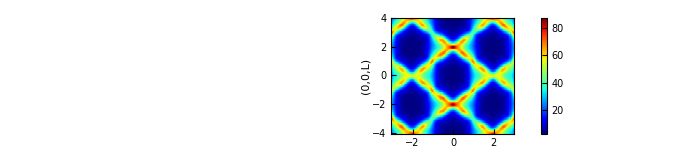

In [53]:
x = np.linspace(-3, 3, num=121, endpoint=True)-3/121.
y = np.linspace(-4, 4, num=161, endpoint=True)-4/161.
X, Y = np.meshgrid(x, y)

sqs = np.reshape([Sq_3nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), 0*DanGd, JexGd, 0, 0,0, DipGd, 3.5) for i in x for j in y], (121, 161)) # dipolar spin ice

plt.figure()
plt.pcolor(X, Y , sqs.T, cmap='jet')
plt.gca().set_aspect(0.707)
plt.xlabel('(H,H,0)',labelpad=1)
plt.ylabel('(0,0,L)',labelpad=1)
plt.colorbar()
plt.show()

## 1D powder

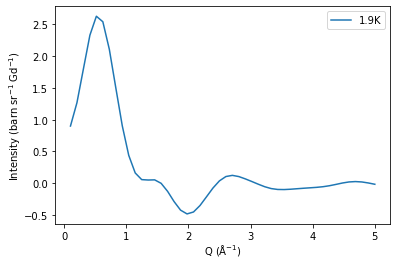

In [16]:
# Reproduce the result in PRL CdEr2S4 by Shang Gao (note: they used dipolar interaction up to 5th u.c.!!!)

x = np.linspace(0.1, 5, num=48, endpoint=True)

sqs1 = np.array(Parallel(n_jobs=48)(delayed(SqPowder_3nnDaJexDip)(i, 10, 0,0,0,0, 0.69/11.6, 1.9) for i in x*aa))

fig = plt.figure()
plt.plot(x, (sqs1[:,0]-6)*gdformfact(x),label='1.9K')
# plt.plot(x, (sqs10[:,0]-6)*gdformfact(x),label='1.9K_with_aniso100')
# plt.plot(x, (sqs2[:,0]-0)*gdformfact(x),label='2.3K')
# plt.plot(x, (sqs3[:,0]-0)*gdformfact(x),label='3.8K')
# plt.plot(x, (sqs4[:,0]-0),label='15.8K')
#plt.xlim([0.25,3])
plt.legend()
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)

plt.show()

# Load data

In [15]:
os.getcwd()

'c:\\Users\\jhxup\\0_MyIpython\\Reverse_MC_result_analysis\\Gd2Hf2O7\\MeanField_RWTH_HPC'

In [4]:
# Load and reduce data
fpath = r"/home/nr571022/jupyterlab/Gd2Hf2O7 mean field"
fpath = os.getcwd()
data_path = os.path.join(fpath, "35mK_data.txt")
data = np.genfromtxt(data_path)

data[:,1] = data[:,1]/gdformfact(data[:,0]) # remove form fatctor
data[:,2] = data[:,2]/gdformfact(data[:,0])

# Get less nb of point for fitting
data_part = data[1::2,:].copy()
data_part[:,0] = data_part[:,0]*aa # convert to reciprocal lattice unit
print(data_part, data_part.shape)

# Plot Bragg positions
hkls = np.array(list(combinations_with_replacement([0,1,2,3,4],r=3)))
hkls_q = LA.norm(hkls, axis=1)*2*np.pi/aa
plt.figure(figsize=[5,4])
plt.errorbar(data[:,0], data[:,1], yerr = data[:,2], fmt='o',ms=2)
plt.errorbar(data_part[:,0]/aa, data_part[:,1], yerr = data_part[:,2], fmt='o',ms=2)
for i in range(len(hkls_q))[1:]:
    color = 'gray'
    if np.all(hkls[i]%2==0) | np.all(hkls[i]%2==1):
        color = 'red' # all even/odd Bragg peaks
    if hkls_q[i] not in hkls_q[0:i]:
        plt.axvline(hkls_q[i],0,1,color=color,lw=0.5)
        plt.text(hkls_q[i], 10, str(hkls[i]), size=10, rotation=90)
    else:
        plt.text(hkls_q[i], 8, str(hkls[i]), size=10, rotation=90)
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)
plt.show()

NameError: name 'gdformfact' is not defined

# Fit

## Function

In [16]:
# Memorize the timeing consuming powder average result if only scale is changed while fitting
# https://www.python-course.eu/python3_memoization.php
class Memoize:
    def __init__(self, fn):
        self.fn = fn
        self.memo = {}
        self.count = 0
        
    def __call__(self, *args):
        self.count += 1
        call_time = time.localtime()
        
        print(time.strftime("%d %b %Y %H:%M:%S, ", call_time), 'Function call count: %3d, ' % self.count, 
              'fit parameters are '+' '.join('{:1.6f}'.format(k) for k in args[0:8]) )
        
        print('run time(s): ', time.mktime(time.localtime())-time.mktime(call_time))
        
        return self.fn(*args)
    
    def refresh(self):
        self.memo = {}
        self.count = 0
        
@Memoize
def parSqs(scale,Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel):
    return scale*np.array(parallel(delayed(SqPowder_3nnDaJexDip)(q, Da, Jex0, Jex1,Jex2a,Jex2b, Dip, T) for q in data_part[:,0]))[:,0]

# Q points for testing if the set parameters gives negative intensity
x = np.linspace(0.1, 3, num=30, endpoint=True)
y = np.linspace(0.1, 4, num=40, endpoint=True)
hhl = np.array([2*np.pi*np.array([i,i,j]) for i in x for j in y])
large_return_for_improper_pars = 10000*np.sum( (data_part[:,1]/data_part[:,2])**2)
    
rem_Target = []
def minTarget_opt_scale(Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel):
    #print(time.strftime("%a, %d %b %Y %H:%M:%S, ", time.gmtime()), 'fit parameters are %1.4f, %1.4f, %1.4f' % (scale, Jex, T))
    # Do not calculate powder average for improper parameters while fitting: if contains negative intensity, wrong and timing consuming
    if np.any(np.array(parallel(delayed(Sq_3nnDaJexDip_fast)(q, Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T) for q in hhl)) <0):
        
        print(time.strftime("%d %b %Y %H:%M:%S, ", time.localtime()), 'Negtive intensity, Powder function not called',
              'fit parameters are '+' '.join('{:1.6f}'.format(k) for k in [Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T]))
        
        rem_Target.append(['Negative Int.', Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T]+['','']) # appending two spaces for making same length with below
        
        return large_return_for_improper_pars
    else:
        sqs = parSqs(1.0, Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel)
        res = minimize(lambda scale: np.sum( ((scale*sqs-data_part[:,1])/data_part[:,2])**2 ), [0.16], bounds=[(0,np.inf)]) # reduced by errorbar
        
        print('Chi^2: %10.4f, Scale: %1.4f, Opt_scale Success: %s' % (res.fun, res.x[0], res.success))
        print('Parameters are: ', Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T)
        
        rem_Target.append([res.fun, res.x[0], res.success] + [Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T])
        
        return res.fun
    
minTarget_opt_scale_vec = np.vectorize(minTarget_opt_scale,  excluded=['parallel'])

def plot_res(scale=1, Da=0, Jex0=-0.166,Jex1=0,Jex2a=0,Jex2b=0, Dip=0.066, T=3., plot_fit=True):
    fig, axs = plt.subplots(ncols=2,nrows=1)
    axs[0].errorbar(data[:,0], data[:,1], yerr = data[:,2],fmt='o',ms=2,label='Data')
    
    if plot_fit:
        xmin, xmax = np.min(data[:,0]), np.max(data[:,0])
        x_long = np.linspace(xmin, xmax, num=50, endpoint=True)
        sqs_fit = np.array(Parallel(n_jobs=46)(delayed(SqPowder_3nnDaJexDip)(q, Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T) \
                                                    for q in x_long*aa))
        #x, y = data[::5,0], scale * sqs_fit[:,0]
        x, y = x_long, scale * sqs_fit[:,0]
        #y2 = np.ma.masked_where( ((x>1.978)&(x<2.11)) | ((x>2.93)&(x<3.17)) | ((x>3.5)&(x<3.57)), y) 
        axs[0].plot(x,y, label='Fit', zorder=10)
        
    axs[0].set_xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
    axs[0].set_ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)
    axs[0].legend()
    #plt.savefig(data_path.replace('.txt', '_fit_3nn.pdf'),bbox_inches="tight",pad_inches=0.01)

    x = np.linspace(-3, 3, num=121, endpoint=True)
    y = np.linspace(-4, 4, num=161, endpoint=True)
    X, Y = np.meshgrid(x, y)
    sqs_hhl = np.reshape([Sq_3nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T) \
                          for i in x for j in y], (121, 161))
    rad = np.sqrt(2*X**2 + Y**2)
    Zm = np.ma.masked_where((rad>4)|(rad<0.01),sqs_hhl.T*gdformfact(rad*2*np.pi/aa))# mask Nan values then plot in white color

    axs[1].pcolor(X, Y , Zm, cmap='jet')
    axs[1].set_aspect(0.707)
    axs[1].set_xlabel('(H,H,0)',labelpad=1)
    axs[1].set_ylabel('(0,0,L)',labelpad=1)  
    #plt.savefig(data_path.replace('.txt', 'hhl_fitted_3nn.pdf'),bbox_inches="tight",pad_inches=0.01)
    plt.show()
    
    return x_long, scale * sqs_fit[:,0] * gdformfact(x_long)

## Fitting

In [33]:
# Internal fit scale
rem_Target = []
parSqs.refresh()

DipGd = 0.066 # including S(S+1), there is a minus sign in the interaction matrix
DanGd = 0.140/11.6 * 3.5*3.5 #meV, need to include S(S+1) or SS found on 2024.03.21; use GdSn one

x_start = np.array([JexGd,  0, 0, 0, 3.1])
x_start = np.array([-0.18189, 0.020874, 0.014147, 0.0044505, 2.0283]) # best from the random fit

tic = time.time()
with Parallel(n_jobs=46) as parallel:
    res = minimize(lambda x: minTarget_opt_scale(DanGd, x[0], x[1], x[2], x[3], DipGd, x[4], parallel), 
                   x_start,
                   bounds=[(-0.6,0),
                           (-0.1*abs(JexGd), 0.1*abs(JexGd)),
                           (-0.1*abs(JexGd), 0.1*abs(JexGd)), 
                           (-0.1*abs(JexGd), 0.1*abs(JexGd)), 
                           (1,10)],
                   method='Nelder-Mead')# method = 'Nelder-Mead')
toc = time.time()-tic

print(res)

'''
scale: 0.1407
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 399.45593024900165
             x: [-1.694e-01  1.457e-02  7.276e-03  4.165e-03  1.871e+00]
           nit: 445
          nfev: 710
 final_simplex: (array([[-1.694e-01,  1.457e-02, ...,  4.165e-03,
                         1.871e+00],
                       [-1.694e-01,  1.458e-02, ...,  4.165e-03,
                         1.871e+00],
                       ...,
                       [-1.694e-01,  1.458e-02, ...,  4.165e-03,
                         1.871e+00],
                       [-1.694e-01,  1.457e-02, ...,  4.165e-03,
                         1.871e+00]]), array([ 3.995e+02,  3.995e+02,  3.995e+02,  3.995e+02,
                        3.995e+02,  3.995e+02]))

Scale: 0.1540
      message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 406.24098979121044
             x: [-1.816e-01  2.122e-02  1.473e-02  3.466e-03  2.034e+00]
           nit: 114
          nfev: 226
 final_simplex: (array([[-1.816e-01,  2.122e-02, ...,  3.466e-03,
                         2.034e+00],
                       [-1.816e-01,  2.122e-02, ...,  3.466e-03,
                         2.034e+00],
                       ...,
                       [-1.816e-01,  2.122e-02, ...,  3.466e-03,
                         2.034e+00],
                       [-1.816e-01,  2.122e-02, ...,  3.466e-03,
                         2.034e+00]]), array([ 4.062e+02,  4.062e+02,  4.062e+02,  4.062e+02,
                        4.062e+02,  4.062e+02]))
'''

02 May 2024 11:00:11,  Function call count:   1,  fit parameters are 1.000000 0.147845 -0.181890 0.020874 0.014147 0.004450 0.066000 2.028300
run time(s):  0.0
Chi^2:   418.0780, Scale: 0.1514, Opt_scale Success: True
Parameters are:  0.14784482758620693 -0.18189 0.020874 0.014147 0.0044505 0.066 2.0283
02 May 2024 11:00:15,  Negtive intensity, Powder function not called fit parameters are 0.147845 -0.190985 0.020874 0.014147 0.004450 0.066000 2.028300
02 May 2024 11:00:16,  Function call count:   2,  fit parameters are 1.000000 0.147845 -0.181890 0.021918 0.014147 0.004450 0.066000 2.028300
run time(s):  0.0
Chi^2:   414.9124, Scale: 0.1499, Opt_scale Success: True
Parameters are:  0.14784482758620693 -0.18189 0.021917700000000002 0.014147 0.0044505 0.066 2.0283
02 May 2024 11:00:20,  Function call count:   3,  fit parameters are 1.000000 0.147845 -0.181890 0.020874 0.014854 0.004450 0.066000 2.028300
run time(s):  0.0
Chi^2:   460.5708, Scale: 0.1475, Opt_scale Success: True
Paramete

'\n       message: Optimization terminated successfully.\n       success: True\n        status: 0\n           fun: 399.45593024900165\n             x: [-1.694e-01  1.457e-02  7.276e-03  4.165e-03  1.871e+00]\n           nit: 445\n          nfev: 710\n final_simplex: (array([[-1.694e-01,  1.457e-02, ...,  4.165e-03,\n                         1.871e+00],\n                       [-1.694e-01,  1.458e-02, ...,  4.165e-03,\n                         1.871e+00],\n                       ...,\n                       [-1.694e-01,  1.458e-02, ...,  4.165e-03,\n                         1.871e+00],\n                       [-1.694e-01,  1.457e-02, ...,  4.165e-03,\n                         1.871e+00]]), array([ 3.995e+02,  3.995e+02,  3.995e+02,  3.995e+02,\n                        3.995e+02,  3.995e+02]))\n'

In [34]:
np.savetxt(os.path.join(fpath, 'rem_Target_fit_j1_j2_j3ab_fixed_Ani140mK_Dip0p066meV_startAtBestRandom.txt'), rem_Target, fmt="%s")

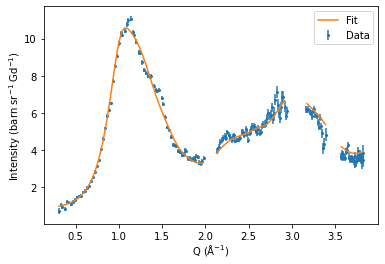

In [39]:
res.x = [-1.694e-01,  1.457e-02,  7.276e-03,  4.165e-03,  1.871e+00]; scale = 0.1408
#res.x = [-1.816e-01,  2.122e-02,  1.473e-02,  3.466e-03,   2.034e+00]; scale = 0.1540 # started at the best of 10e4 stocatic search
#Jex1, Jex2, Jex3a, Jex3b, T with scale = 0.1612

plt.figure()
plt.errorbar(data[:,0], data[:,1], yerr = data[:,2], fmt='o',ms=2,label='Data')

sqs_fit = np.array(Parallel(n_jobs=46)(delayed(SqPowder_3nnDaJexDip)(q, DanGd, res.x[0], res.x[1], res.x[2], res.x[3], DipGd, res.x[4]) \
                                             for q in data[:,0]*aa))

x, y = data[:,0], scale* sqs_fit[:,0]
y2 = np.ma.masked_where( ((x>1.978)&(x<2.11)) | ((x>2.93)&(x<3.17)) | ((x>3.5)&(x<3.57)), y) 

plt.plot(data[:,0], y2, label='Fit', zorder=10)
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)
plt.legend()
#plt.savefig(data_path.replace('.txt', '_fit_3nn.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

# Random starting parameters

## Function

In [20]:
x = np.linspace(0.1, 3, num=30, endpoint=True)
y = np.linspace(0.1, 4, num=40, endpoint=True)
hhl = np.array([2*np.pi*np.array([i,i,j]) for i in x for j in y])

def check_opt_scale(Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel):
    # Do not calculate powder average for improper parameters while fitting: if contains negative intensity, wrong and timing consuming
    if np.any(np.array(parallel(delayed(Sq_3nnDaJexDip_fast)(q, Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T) for q in hhl)) <0):
        #print(time.strftime("%d %b %Y %H:%M:%S, ", time.localtime()), 'Negtive intensity, Powder function not called',
        #      'fit parameters are '+' '.join('{:1.6f}'.format(k) for k in [Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T]))
        return [False]
    else:
        sqs = parSqs(1.0, Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel)
        res = minimize(lambda scale: np.sum( ((scale*sqs-data_part[:,1])/data_part[:,2])**2 ), [0.16], bounds=[(0,np.inf)]) # reduced by errorbar
        
        print('Chi^2: %10.4f, Scale: %1.4f, Opt_scale Success: %s' % (res.fun, res.x[0], res.success))
        print('Fit parameters are '+' '.join('{:1.6f}'.format(k) for k in [Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T]))
        #          0       1       2     3   4   5     6      7   8   9
        return res.fun, res.x[0], Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T, True

## Fitting

In [ ]:
parSqs.refresh()
record = []

iters=0
max_iters = 2000
with Parallel(n_jobs=46) as parallel:
    while iters<max_iters:
        # rd = (np.random.rand(4)-0.5)/0.5  # Four random number in range [-1,1]
        # j0, j1, j2a, j2b, T = -0.17+0.075*rd[0], 0.02*rd[1], 0.02*rd[2], 0.01*rd[3], 3.5-np.random.rand(1)[0]
        rd = (np.random.rand(5)-0.5)/0.5  # Five random number in range [-1,1]
        fit = np.array([-1.694e-01,  1.457e-02,  7.276e-03,  4.165e-03, 1.871e+00])
        
        #trys = fit* (1+rd)
        # j0, j1, j2a, j2b, T = trys
        
        trys = fit* (1+0.5*rd)
        j0, j1, j2a, j2b, T = trys[0], trys[1], 0.0075+0.0075*rd[2], 0.0025+0.005*rd[3], trys[4]

        # TODO: random with fiting T
        
        res = check_opt_scale(DanGd, j0, j1, j2a,j2b, DipGd, T, parallel)
        if res[-1]:
            record.append(res)
            iters+=1
            print(iters)
        else:
            continue
    
record = np.array(record)     

with open(os.path.join(fpath, 'random_3000.txt'), "a") as f:
    #f.write(b"\n")
    np.savetxt(f, record)
    
f.close()   

01 May 2024 21:54:01,  Function call count:   1,  fit parameters are 1.000000 0.147845 -0.086407 0.014382 0.009794 0.007006 0.066000 2.160589
run time(s):  0.0
Chi^2: 17753.9699, Scale: 0.3958, Opt_scale Success: True
Fit parameters are 0.147845 -0.086407 0.014382 0.009794 0.007006 0.066000 2.160589
1
01 May 2024 21:54:04,  Function call count:   2,  fit parameters are 1.000000 0.147845 -0.214087 0.017908 0.000563 0.003225 0.066000 2.215811
run time(s):  0.0
Chi^2:  1467.1410, Scale: 0.1451, Opt_scale Success: True
Fit parameters are 0.147845 -0.214087 0.017908 0.000563 0.003225 0.066000 2.215811
2
01 May 2024 21:54:08,  Function call count:   3,  fit parameters are 1.000000 0.147845 -0.130127 0.008579 0.005536 -0.002316 0.066000 2.616005
run time(s):  0.0
Chi^2: 14055.5711, Scale: 0.4768, Opt_scale Success: True
Fit parameters are 0.147845 -0.130127 0.008579 0.005536 -0.002316 0.066000 2.616005
3
01 May 2024 21:54:09,  Function call count:   4,  fit parameters are 1.000000 0.147845 -0

## Results

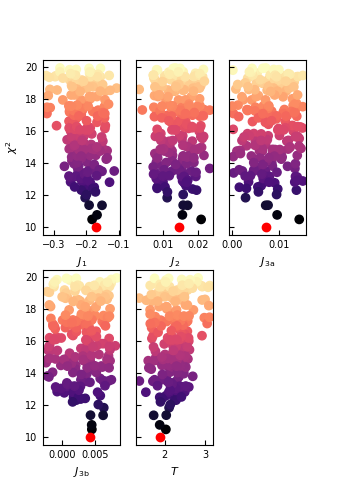

(10100, 10)


array([ 4.18099863e+02,  1.51390205e-01,  1.47844828e-01, -1.81893501e-01,
        2.08742168e-02,  1.41468276e-02,  4.45052389e-03,  6.60000000e-02,
        2.02830276e+00,  1.00000000e+00])

In [8]:
# Polt chi2-parameter subplots
fpath = os.getcwd()
record = np.genfromtxt(os.path.join(fpath,'random_3000.txt'))
fit = np.array([-1.694e-01,  1.457e-02,  7.276e-03,  4.165e-03, 1.871e+00])
fit2= np.array([-1.816e-01,  2.122e-02,  1.473e-02,  3.466e-03, 2.034e+00])

latexify(fig_height=5)
# fig, axs = plt.subplots(figsize=(10,2), nrows=2, ncols=3, sharey=True)
fig, axs = plt.subplots( nrows=2, ncols=3, sharey=True)
axs = axs.flat
lables = ['$J_1$','$J_2$', r'$J_\mathrm{3a}$', r'$J_\mathrm{3b}$','$T$']

for ax,lable in zip(axs, lables):
    ax.set_xlabel(lable)
axs[0].set_ylabel('$\chi^2$')

record = np.array(record)
ma0 = record[:,0]<800
ma1 = (record[:,6]>-0.01) & (record[:,6]<0.01)
ma = ma0 & ma1
normerr = 46-6 # normailzing the error: npts-nbPars (ref. PyCrystalField)
for idx, i in enumerate([3,4,5,6,8]):
    axs[idx].scatter(record[ma,i], record[ma,0]/normerr,  c=record[ma,0]/normerr, cmap='magma')
    axs[idx].scatter(fit[idx],399/normerr,c='r')
    #axs[idx].scatter(fit2[idx],406/normerr,c='blue')
    
axs[-1].set_visible(False)

fig.savefig(os.path.join(fpath,'random_fit_chi_pars2.pdf'),bbox_inches="tight",pad_inches=0.01)    

plt.show()

print(record.shape)
record[np.nanargmin(record[:,0]),:]

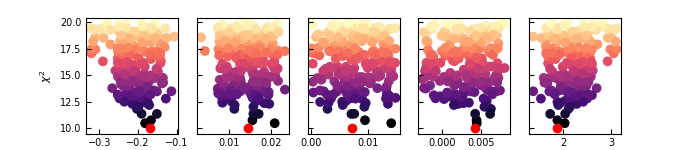

(10100, 10)


array([ 4.18099863e+02,  1.51390205e-01,  1.47844828e-01, -1.81893501e-01,
        2.08742168e-02,  1.41468276e-02,  4.45052389e-03,  6.60000000e-02,
        2.02830276e+00,  1.00000000e+00])

In [16]:
latexify(fig_height=1.5,columns=2)
fig, axs = plt.subplots( nrows=1, ncols=5, sharey=True)
axs = axs.flat
lables = ['$J_1$','$J_2$', r'$J_\mathrm{3a}$', r'$J_\mathrm{3b}$','$T$']

for ax,lable in zip(axs, lables):
    ax.set_xlabel(lable)
axs[0].set_ylabel('$\chi^2$')

record = np.array(record)
ma0 = record[:,0]<800
ma1 = (record[:,6]>-0.01) & (record[:,6]<0.01)
ma = ma0 & ma1
normerr = 46-6 # normailzing the error: npts-nbPars (ref. PyCrystalField)
for idx, i in enumerate([3,4,5,6,8]):
    axs[idx].scatter(record[ma,i], record[ma,0]/normerr,  c=record[ma,0]/normerr, cmap='magma')
    axs[idx].scatter(fit[idx],399/normerr,c='r')
    #axs[idx].scatter(fit2[idx],406/normerr,c='blue')

fig.savefig(os.path.join(fpath,'random_fit_chi_pars3.pdf'),bbox_inches="tight",pad_inches=0.01)    

plt.show()

print(record.shape)
record[np.nanargmin(record[:,0]),:]

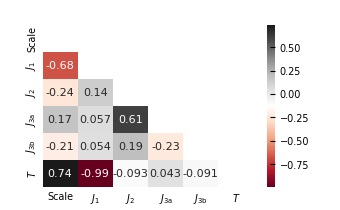

In [10]:
import pandas as pd
import seaborn as sns
latexify()
df = pd.DataFrame(data=record[:,[1,3,4,5,6,8]][ma,:], 
                  columns= ['Scale','$J_1$','$J_2$', r'$J_\mathrm{3a}$', r'$J_\mathrm{3b}$','$T$'])
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool),k=0)

fig, ax = plt.subplots()
sns.heatmap(df.corr(), mask=mask, annot=True,cmap='RdGy')
ax.tick_params(left=False, bottom=False)
fig.savefig(os.path.join(fpath,'random_fit_corr_chi2_less600_2.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

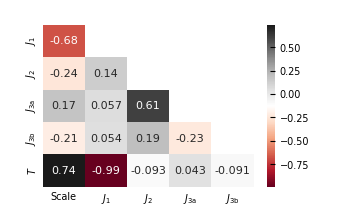

In [24]:
# Corr heatmap without diagonal
import pandas as pd
import seaborn as sns

df = pd.DataFrame(data=record[:,[1,3,4,5,6,8]][ma,:], 
                  columns= ['Scale','$J_1$','$J_2$', r'$J_\mathrm{3a}$', r'$J_\mathrm{3b}$','$T$'])
corr = df.corr()

dat = corr.to_numpy()[1:,:-1]
mask = ~np.tril(np.ones_like(dat, dtype=bool),k=0)

xlabels = ['Scale','$J_1$','$J_2$', r'$J_\mathrm{3a}$', r'$J_\mathrm{3b}$']
ylabels = ['$J_1$','$J_2$', r'$J_\mathrm{3a}$', r'$J_\mathrm{3b}$','$T$']

fig, ax = plt.subplots()
sns.heatmap(data=dat, mask=mask, annot=True,cmap='RdGy', xticklabels=xlabels,yticklabels=ylabels)
ax.tick_params(left=False, bottom=False)
#fig.savefig(os.path.join(fpath,'random_fit_corr_chi2_less600.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

C:\Users\jhxup\AppData\Local\Temp\ipykernel_19428\3317825621.py:24: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  text = ax.text(j, i, "{:.2g}".format(dat[i, j]),


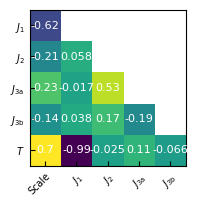

In [50]:
# Corr heatmap without diagonal: try matplotlib
import matplotlib as mpl

ylabels = ['$J_1$','$J_2$', r'$J_\mathrm{3a}$', r'$J_\mathrm{3b}$','$T$']
xlabels = ['Scale','$J_1$','$J_2$', r'$J_\mathrm{3a}$', r'$J_\mathrm{3b}$']

dat = corr.to_numpy()[1:,:-1]
dat =np.ma.masked_where(~np.tril(np.ones_like(dat, dtype=bool),k=0), dat)

fig, ax = plt.subplots()
im = ax.imshow(dat)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(xlabels)), labels=xlabels)
ax.set_yticks(np.arange(len(ylabels)), labels=ylabels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(ylabels)):
    for j in range(len(xlabels)):
        text = ax.text(j, i, "{:.2g}".format(dat[i, j]),
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.show()

<Figure size 288x288 with 0 Axes>

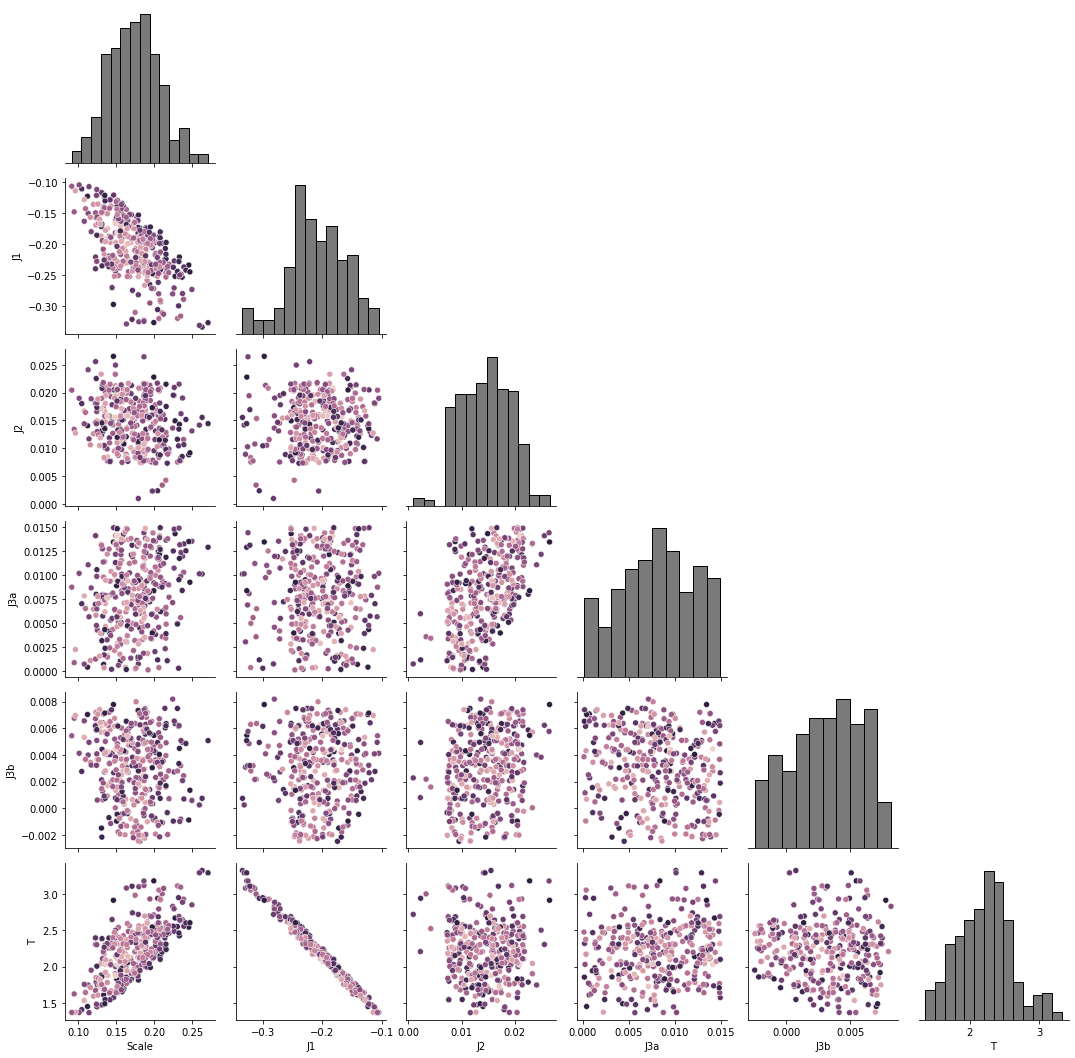

In [23]:
plt.figure(figsize=(4,4))
df = pd.DataFrame(data=record[:,[0,1,3,4,5,6,8]][ma,:], columns=['Chi2','Scale','J1','J2', 'J3a', 'J3b','T'])
g = sns.PairGrid(df, hue='Chi2', diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, hue=None, color=".3")
#g.savefig(os.path.join(fpath, 'pair_grid_chi600.pdf'))
plt.show()

# Fit all data

## Fit all

In [18]:
fnames = ['35mK_data.txt','1K_data.txt','2K_data.txt','4K_data.txt','8K_data.txt','30K_data.txt']
x0 = [2.6, 3, 5, 6, 20] # T
fit = np.array([DanGd, -1.694e-01, 1.457e-02, 7.276e-03, 4.165e-03, DipGd])

In [64]:
for idx, fname in enumerate(['30K_data.txt']):
    fpath_name = os.path.join(fpath,fname)
    print(fpath_name)
    
    data = np.genfromtxt(fpath_name)
    data[:,1] = data[:,1]/gdformfact(data[:,0]) # remove form fatctor
    data[:,2] = data[:,2]/gdformfact(data[:,0])

    # Get less nb of point for fitting
    data_part = data[1::2,:].copy()
    data_part[:,0] = data_part[:,0]*aa # convert to reciprocal lattice unit
    print(data_part, data_part.shape)

    # Fit
    rem_Target = []
    parSqs.refresh()

    x_start = [x0[idx]]

    with Parallel(n_jobs=48) as parallel:
        res = minimize(lambda x: minTarget_opt_scale(fit[0],fit[1],fit[2],fit[3], fit[4], fit[5], x[0], parallel), 
                    x_start,
                    bounds=[(1,20)],
                    method='Nelder-Mead')

    print(res)
    # np.savetxt(os.path.join(fpath, 'rem_Target_fit_only_T'+fname), rem_Target, fmt="%s")

/home/nr571022/jupyterlab/30K_data.txt
[[3.3252 4.0084 0.26977]
 [3.7451 4.0094 0.23204]
 [4.1771 4.0811 0.19381]
 [4.6159 4.4967 0.20059]
 [5.0009 4.7568 0.16187]
 [5.3897 4.7298 0.1824]
 [5.8052 4.962 0.16319]
 [6.2239 4.3156 0.17279]
 [6.6442 4.8702 0.1597]
 [7.0843 5.1767 0.17007]
 [7.517 5.0826 0.17675]
 [7.8996 5.0148 0.16251]
 [8.2841 4.9067 0.17751]
 [8.6939 5.0807 0.15512]
 [9.1079 5.2847 0.18115]
 [9.5206 5.6349 0.16437]
 [9.9563 5.3359 0.18194]
 [10.381 5.5287 0.19862]
 [10.759 5.4296 0.18284]
 [11.137 5.6309 0.18161]
 [11.54 5.8916 0.17904]
 [11.947 5.6535 0.18613]
 [12.35 5.7752 0.18003]
 [12.779 6.3707 0.19582]
 [13.193 5.7535 0.20788]
 [13.565 5.423 0.18275]
 [13.935 5.3988 0.20407]
 [14.328 5.3237 0.17774]
 [14.726 5.5982 0.17641]
 [15.118 5.6086 0.16484]
 [15.538 5.7079 0.18169]
 [15.94 5.5306 0.20065]
 [16.304 5.1774 0.18927]
 [16.664 5.3018 0.2168]
 [17.045 5.1189 0.18081]
 [17.551 4.592 0.2168]
 [17.938 5.2236 0.24312]
 [18.367 4.9768 0.24095]
 [18.76 5.4171 0.26452

## Plot all 1D data and fit

/home/nr571022/jupyterlab/35mK_data.txt


NameError: name 'SqPowder_3nnDaJexDip' is not defined

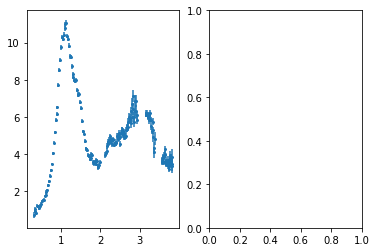

In [19]:
# Plot all
scales = [0.1861, 0.2445, 0.3403, 0.6129, 1.1311, 3.1287]
Ts = [2.699, 2.787, 3.042, 3.913, 6.015, 15]
scales = [0.1408, 0.1845,0.2616,0.4905,0.9334,2.6559]
Ts     = [1.871,  1.938, 2.144, 2.877, 4.668, 12.41]

for idx, fname in enumerate(fnames):
    
    fpath_name = os.path.join(fpath,fname)
    print(fpath_name)

    data = np.genfromtxt(fpath_name)
    data[:,1] = data[:,1]/gdformfact(data[:,0]) # remove form fatctor
    data[:,2] = data[:,2]/gdformfact(data[:,0])

    # Get less nb of point for fitting
    data_part = data[1::2,:].copy()
    data_part[:,0] = data_part[:,0]*aa # convert to reciprocal lattice unit

    x_long, fit_sqs = plot_res(scale=scales[idx], Da=fit[0], Jex0=fit[1],Jex1=fit[2],Jex2a=fit[3],Jex2b=fit[4], Dip=fit[5], T=Ts[idx], plot_fit=True)
    # np.savetxt(fpath_name.replace('.txt', '_MF_fit.txt'), np.vstack([x_long, fit_sqs]).T)

30K_data.txt
8K_data.txt
4K_data.txt
2K_data.txt
1K_data.txt
35mK_data.txt
c:\Users\jhxup\0_MyIpython\Reverse_MC_result_analysis\Gd2Hf2O7\MeanField_RWTH_HPC\35mK_data_MF_fit.txt
c:\Users\jhxup\0_MyIpython\Reverse_MC_result_analysis\Gd2Hf2O7\MeanField_RWTH_HPC\1K_data_MF_fit.txt
c:\Users\jhxup\0_MyIpython\Reverse_MC_result_analysis\Gd2Hf2O7\MeanField_RWTH_HPC\2K_data_MF_fit.txt
c:\Users\jhxup\0_MyIpython\Reverse_MC_result_analysis\Gd2Hf2O7\MeanField_RWTH_HPC\4K_data_MF_fit.txt
c:\Users\jhxup\0_MyIpython\Reverse_MC_result_analysis\Gd2Hf2O7\MeanField_RWTH_HPC\8K_data_MF_fit.txt
c:\Users\jhxup\0_MyIpython\Reverse_MC_result_analysis\Gd2Hf2O7\MeanField_RWTH_HPC\30K_data_MF_fit.txt


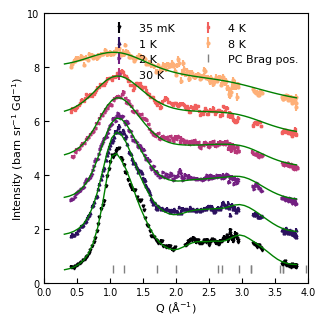

In [17]:
# Combined 1D plot
# First run the sectoin "fname: Save xy.dat from xye..."
fnames = ['35mK_data.txt','1K_data.txt','2K_data.txt','4K_data.txt','8K_data.txt', '30K_data.txt']

# All data
legs = ['35 mK', '1 K', '2 K', '30 K', '4 K', '8 K', '30 K']
markers = ['o','s','<', '>', '^','v','+']
latexify(fig_height=3.5)
fig = plt.figure()
colors = plt.cm.magma(np.linspace(1,0,7)[1:])

for idx, i in enumerate(reversed(range(6))): #enumerate(reversed([3,0,1,4,5,2])):
    print(fnames[i])
    new_dat = np.genfromtxt(fnames[i])
    x,y,e = new_dat[:,0], new_dat[:,1]/2+(5-idx)*1.2, new_dat[:,2]/2 # /2: per Gd
    y = np.ma.masked_where( ((x>0)&(x<0.4)) | ((x>2.95)&(x<3.1)) | ((x>3.3)&(x<3.6)), y) 
    plt.errorbar(x, y, yerr = e, c=colors[idx], fmt=markers[idx],ms=2,label=legs[i])

for idx, i in enumerate(fnames):
    temp = os.path.join(fpath, fnames[idx].replace('.txt', '_MF_fit.txt'))
    print(temp)
    fit = np.genfromtxt(temp)
    plt.plot(fit[:,0], fit[:,1]/2+idx*1.2, c='g',lw=1, zorder=10)
    
##Brag positions
### General
# imax = 4
# for h in np.arange(0,imax):
#     for k in np.arange(h,imax):
#         for l in np.arange(k,imax):
#             if h==k==l==0:
#                 continue
            
#             q = 2*np.pi/10.44 * np.sqrt(h**2+k**2+l**2) # a=10.4 for D7 and 10.5 for D20
        
#             if q>3:
#                 continue
#             ax.axvline(q, 0,0.75, c='grey',alpha=0.5,zorder=0)
#             ax.text(q-0.08, 8, '[{:d},{:d},{:d}]'.format(h,k,l),rotation=90)

### Brag positions for PC phase
hkls = np.array([[1,1,1],[2,0,0],[2,2,0],[3,1,1],[3,3,1],[4,2,0],[4,2,2],[3,3,3],[5,1,1],[5,3,1],[4,4,2],[6,0,0],[5,3,3]])
qs = []
for hkl in hkls:
    h, k, l = hkl
    q = 2*np.pi/aa * np.sqrt(h**2+k**2+l**2) # a=10.4 for D7 and 10.5 for D20
    qs.append(q)
    
# for hkl,q in zip(hkls, qs):
#     if q>3.8:
#         continue
#     h, k, l = hkl
#     ax.axvline(q, 0.05,0.1, c='grey',alpha=1,zorder=0)
    #ax.text(q-0.08, 13, '[{:d},{:d},{:d}]'.format(h,k,l),rotation=90)
    
plt.plot(qs, np.full_like(qs, 0.5),'|',c='gray', label='PC Brag pos.')

h,l = plt.gca().get_legend_handles_labels()
plt.legend(reversed(h),reversed(l),frameon=False, ncols=2)
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)
ax = plt.gca()
ax.set_xlim([0,4.0])
ax.set_ylim([0,10])
fig.savefig(fpath+'nd_all_data_mf_fit.pdf', bbox_inches="tight", pad_inches=0.01)
plt.show()

## Plot 2D HHL plane at 35mK

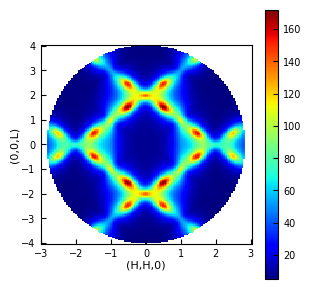

In [18]:

fit = np.array([-1.694e-01,  1.457e-02,  7.276e-03,  4.165e-03, 1.871e+00])

x = np.linspace(-3, 3, num=121, endpoint=True)
y = np.linspace(-4, 4, num=161, endpoint=True)
X, Y = np.meshgrid(x, y)


sqs_hhl = np.reshape([Sq_3nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), DanGd, fit[0], fit[1], fit[2], fit[3], DipGd, fit[4]) for i in x for j in y], (121, 161))

rad = np.sqrt(2*X**2 + Y**2)
Zm = np.ma.masked_where((rad>4)|(rad<0.01),sqs_hhl.T*gdformfact(rad*2*np.pi/aa))# mask Nan values then plot in white color
    
plt.figure()
plt.pcolor(X, Y , Zm, cmap='jet')
plt.gca().set_aspect(0.707)
plt.xlabel('(H,H,0)',labelpad=1)
plt.ylabel('(0,0,L)',labelpad=1)  
plt.colorbar()
#plt.savefig(data_path.replace('.txt', 'hhl_fitted_3nn.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

In [19]:
np.savetxt(os.path.join(fpath,'sqs_hhl.txt'),sqs_hhl)